In [1]:
import os
import scipy.io
import numpy as np
import statistics, math
import matplotlib.pyplot as plt
from libs import util_matlab as umatlab
from libs import datasets, dataset_utils, utils
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
data_dir="/Users/alfonso/matlab/IndirectAcquisition/keras/dataforMarius"
files = [os.path.join(data_dir, file_i) for file_i in os.listdir(data_dir) if file_i.endswith('.mat')]

In [138]:
matlabStruct=umatlab.loadmat(files[1]).get('data')
waveIn=matlabStruct.get('waveIn')
controlNames=matlabStruct.get('controlNames')
indexVel=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'abs(velocity)'][0]
indexForce=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'forceN'][0]

energyBand=matlabStruct.get('energyBand')
energyBand=(energyBand /120 )+1 #normalize [0-1]
audioSR=matlabStruct.get('audioSR')
totalSecs=matlabStruct.get('waveIn').shape[0]/audioSR
energyBands_sr=240 #energyBand.shape[1]/totalSecs #This is around 100Hz-10ms

# We want 6seconds of audio in our window
winLSecs=0.05
windowSize=int((winLSecs*energyBands_sr)//2*2)
windowSizeAudio=int((winLSecs*audioSR)//2*2)
# And we'll move our window by 250 ms at a time
hopSize=windowSize//2
hopSizeAudio=windowSizeAudio//2
n_hops = (energyBand.shape[1]) // hopSize
print('windowSize', windowSize)
print('windowSizeAudio', windowSizeAudio)

windowSize 12
windowSizeAudio 2204


In [59]:
audioSR

44100

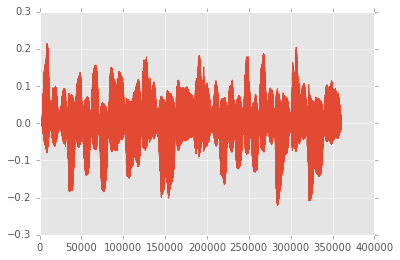

In [6]:
plt.plot(waveIn)

In [139]:
Xs = []
ys = []

# Let's start with the music files
for filename in files:
    #print(filename)
    matlabStruct=umatlab.loadmat(filename).get('data')
    waveIn=matlabStruct.get('waveIn')
    controlData=matlabStruct.get('controlData')
    #target=(controlData[indexForce,:]+0.2)/2
    target=controlData[indexVel,:]/150
    
    n_hops = target.shape[0] // hopSize
    n_hops_Audio = waveIn.shape[0] // hopSizeAudio
    #print('n_hops target:', n_hops)
    #print('n_hops Audio:', n_hops_Audio)
    
    #print(n_frames_per_second, n_frames, frame_hops, n_hops)
    n_hops=int(n_hops)-1
    for hop_i in range(n_hops):
        # Creating our sliding window
        framesIn = waveIn[(hop_i * hopSizeAudio):(hop_i * hopSizeAudio + windowSizeAudio)] #
        if framesIn.shape[0]==windowSizeAudio:
            Xs.append(framesIn[..., np.newaxis])
            # And then store the vel 
            framesOut=target[(hop_i * hopSize):(hop_i * hopSize + windowSize)]
            ys.append(framesOut)
        else:
            #print('warning:filename', filename, ':frame: ',hop_i)
            break

Xs = np.array(Xs)
ys = np.array(ys)
print(Xs.shape, ys.shape)

(93414, 2204, 1) (93414, 12)


In [140]:
ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], n_classes=0)

In [141]:
k_w=5
filterWSecs=k_w/energyBands_sr
filterWSecs

0.020833333333333332

In [183]:

tf.reset_default_graph()

# Create the input to the network.  This is a 4-dimensional tensor!
# Recall that we are using sliding windows of our magnitudes (TODO):
X = tf.placeholder(name='X', shape=(None,Xs.shape[1],Xs.shape[2]), dtype=tf.float32)

# Create the output to the network.  This is our one hot encoding of 2 possible values (TODO)!
Y = tf.placeholder(name='Y', shape=(None,windowSize), dtype=tf.float32)
# TODO:  Explore different numbers of layers, and sizes of the network
n_filters = [40,40,40]

# Now let's loop over our n_filters and create the deep convolutional neural network
H = X
for layer_i, n_filters_i in enumerate(n_filters):
    
    # Let's use the helper function to create our connection to the next layer:
    # TODO: explore changing the parameters here:
    
    H, W = utils.conv1d(H, n_filters_i, k_w=100, d_w=4, padding='SAME', name=str(layer_i))
    
    # And use a nonlinearity
    # TODO: explore changing the activation here:
    H = tf.nn.softplus(H)
    
    # Just to check what's happening:
    print(H.get_shape().as_list())

[None, 551, 40]
[None, 138, 40]
[None, 35, 40]


In [184]:
dims=H.get_shape().as_list()
H_flat= tf.reshape(H, shape=[-1, dims[1] * dims[2] ])
H_flat.get_shape().as_list()

[None, 1400]

In [185]:
# Connect the last convolutional layer to a fully connected network
fc, W = utils.linear(H_flat, n_output=100, name="fcn", activation=tf.nn.relu)
#fc2, W = utils.linear(fc, n_output=50, name="fcn2", activation=tf.nn.relu)
#fc3, W = utils.linear(fc2, n_output=10, name="fcn3", activation=tf.nn.relu)

# And another fully connceted network, now with just n_classes outputs, the number of outputs
Y_pred, W = utils.linear(fc, n_output=windowSize, name="pred", activation=tf.nn.sigmoid)

In [186]:
loss = tf.squared_difference(Y_pred,Y)
cost = tf.reduce_mean(tf.reduce_sum(loss, 1))
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [187]:
# Explore these parameters: (TODO)
n_epochs = 10
batch_size = 400

# Create a session and init!
sess = tf.Session()
#saver = tf.train.Saver()
sess.run(tf.initialize_all_variables())

In [188]:
# Now iterate over our dataset n_epoch times
n_epochs = 10
for epoch_i in range(n_epochs):
    print('Epoch: ', epoch_i)
    
    # Train
    this_cost = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.train.next_batch(batch_size):
        # Note here: we are running the optimizer so
        # that the network parameters train!
        this_cost += sess.run([cost, optimizer], feed_dict={
                X:Xs_i, Y:ys_i})[0]
        its += 1
        #print(this_cost / its)
    print('Training cost: ', this_cost / its)
    
    # Validation (see how the network does on unseen data).
    this_cost = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.valid.next_batch(batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        this_cost += sess.run(cost, feed_dict={
                X:Xs_i, Y:ys_i})
        its += 1
    print('Validation cost: ', this_cost / its)

Epoch:  0
Training cost:  0.263312332611
Validation cost:  0.199850362415
Epoch:  1
Training cost:  0.205490236773
Validation cost:  0.200472829863
Epoch:  2


KeyboardInterrupt: 

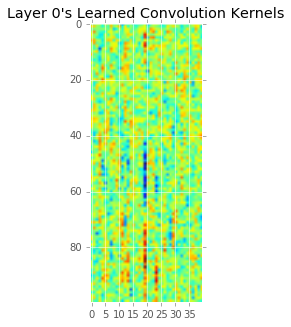

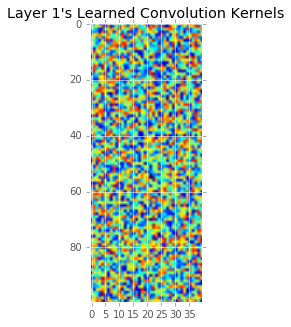

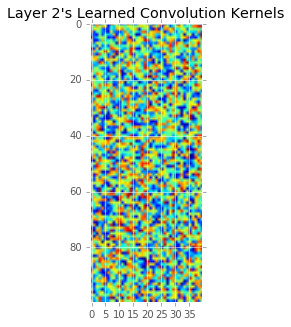

In [189]:
g = tf.get_default_graph()
for layer_i in range(len(n_filters)):
    W = sess.run(g.get_tensor_by_name('{}/W:0'.format(layer_i)))
    plt.figure(figsize=(5, 5))
    #plt.imshow(utils.montage_filters(W))
    plt.imshow(W[:,0,:])
    plt.title('Layer {}\'s Learned Convolution Kernels'.format(layer_i))

In [190]:
Xs_i, ys_i = next(ds.train.next_batch())
prediction=sess.run([Y_pred], feed_dict={X:Xs_i, Y:ys_i})[0]

(0, 1)

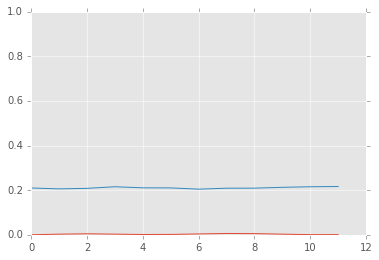

In [191]:
i=10
plt.plot(ys_i[i,:])
plt.plot(prediction[i,:])
plt.ylim((0, 1))

In [175]:
print(Xs_i.shape)
print(ys_i.shape)
print(windowSizeAudio)
print(prediction.shape)

(100, 2204, 1)
(100, 12)
2204
(100, 12)


In [192]:
Xs_i=np.zeros(shape=(100,windowSizeAudio,1))
ys_i=np.zeros(shape=(100,windowSize))
for i in range(50):
    Xs_i[i,:,0]=waveIn[i*windowSizeAudio:i*windowSizeAudio+windowSizeAudio]
    ys_i[i,:]=target[i*windowSize:i*windowSize+windowSize]

In [193]:
prediction=sess.run([Y_pred], feed_dict={X:Xs_i, Y:ys_i})[0]
linPrediction = np.reshape(prediction, (np.product(prediction.shape)))
linOriginal = np.reshape(ys_i, (np.product(ys_i.shape)))

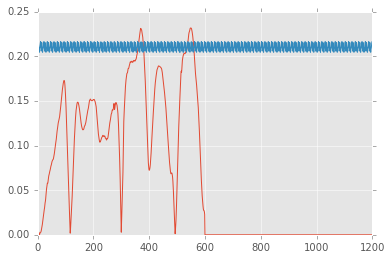

In [194]:
plt.plot(linOriginal)
plt.plot(linPrediction)